
# Task 1 — MACCS (self split) → RF & SVR on AqSolDB

This notebook:
1. Loads **standardized_AqSolDB.csv** (same folder or `./data/`)
2. Creates a **reproducible 80/20 split** (seed=42) **and saves** the split IDs
3. Featurizes with **MACCS (167-bit)** via RDKit
4. Trains **RandomForestRegressor** and **SVR (RBF)** with 5-fold CV on train only
5. Evaluates both on the **held-out test set** (RMSE, MAE, R²)
6. Saves models, metrics, figures, and a small manifest


In [1]:

# (Recommended: use a conda/mamba env with rdkit installed)
import os, json, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from typing import Tuple, List, Optional
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

SEED = 42
np.random.seed(SEED)

BASE = Path('.')
DATA_DIR = BASE / 'data'
SPLITS_DIR = DATA_DIR / 'splits'
PROC_DIR = DATA_DIR / 'processed'
MODELS_DIR = Path('models')
FIG_DIR = Path('figures')
RESULTS_DIR = Path('results')

for d in [DATA_DIR, SPLITS_DIR, PROC_DIR, MODELS_DIR, FIG_DIR, RESULTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

STD_CSV_CANDIDATES = [
    'standardized_AqSolDB.csv',
    DATA_DIR / 'standardized_AqSolDB.csv',
    'AqSolDB_clean.csv',
    DATA_DIR / 'AqSolDB_clean.csv'
]


In [2]:

from typing import Sequence

def find_standardized_csv(candidates: Sequence[Path]) -> Path:
    for c in candidates:
        c = Path(c)
        if c.exists():
            return c
    raise FileNotFoundError("Place 'standardized_AqSolDB.csv' next to this notebook or in ./data/")

def guess_columns(df: pd.DataFrame) -> Tuple[str, str]:
    smiles_candidates = [c for c in df.columns if 'smiles' in c.lower()]
    if not smiles_candidates:
        raise ValueError(f"No SMILES-like column found. Columns: {list(df.columns)}")
    smiles_col = smiles_candidates[0]
    y_candidates = [c for c in df.columns if c.lower() in ('logs','log_s','logsol','log_solu','target','y','solubility','aqsol')]
    if not y_candidates:
        numeric_cols = [c for c in df.columns if c != smiles_col and pd.api.types.is_numeric_dtype(df[c])]
        if not numeric_cols:
            raise ValueError("No numeric target column found. Rename your target to 'LogS'.")
        y_col = numeric_cols[0]
    else:
        y_col = y_candidates[0]
    return smiles_col, y_col


In [3]:

std_path = find_standardized_csv(STD_CSV_CANDIDATES)
print(f"Using standardized data at: {std_path}")
df = pd.read_csv(std_path)
print(df.head(3))
print(f"Rows: {len(df)} | Columns: {list(df.columns)}")

smiles_col, y_col = guess_columns(df)
print(f"Detected SMILES column: {smiles_col} | target column: {y_col}")

id_col = None
for c in ['inchikey', 'InChIKey', 'canonical_smiles', 'can_smiles', 'id']:
    if c in df.columns:
        id_col = c
        break

if id_col is None:
    def to_canonical(s):
        try:
            m = Chem.MolFromSmiles(str(s))
            return Chem.MolToSmiles(m, canonical=True) if m is not None else None
        except Exception:
            return None
    df['canonical_smiles'] = df[smiles_col].apply(to_canonical)
    id_col = 'canonical_smiles'

df = df.dropna(subset=[id_col, y_col]).copy()
before = len(df)
df = df.drop_duplicates(subset=[id_col]).copy()
after = len(df)
print(f"De-duplicated by {id_col}: {before} -> {after}")


Using standardized data at: standardized_AqSolDB.csv
   Unnamed: 0                               SMILES      LogS  \
0           0  [Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C -3.616127   
1           1                 O=C1Nc2cccc3cccc1c23 -3.254767   
2           2                      Clc1ccc(C=O)cc1 -2.177078   

                   Standardized_SMILES  
0  CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-]  
1                 O=C1Nc2cccc3cccc1c23  
2                      O=Cc1ccc(Cl)cc1  
Rows: 9980 | Columns: ['Unnamed: 0', 'SMILES', 'LogS', 'Standardized_SMILES']
Detected SMILES column: SMILES | target column: LogS


[14:33:49] WARNING: not removing hydrogen atom without neighbors
[14:33:49] WARNING: not removing hydrogen atom without neighbors
[14:33:49] WARNING: not removing hydrogen atom without neighbors
[14:33:49] WARNING: not removing hydrogen atom without neighbors
[14:33:49] WARNING: not removing hydrogen atom without neighbors
[14:33:49] WARNING: not removing hydrogen atom without neighbors
[14:33:49] WARNING: not removing hydrogen atom without neighbors
[14:33:49] WARNING: not removing hydrogen atom without neighbors
[14:33:49] WARNING: not removing hydrogen atom without neighbors
[14:33:49] WARNING: not removing hydrogen atom without neighbors
[14:33:49] WARNING: not removing hydrogen atom without neighbors
[14:33:49] WARNING: not removing hydrogen atom without neighbors
[14:33:49] WARNING: not removing hydrogen atom without neighbors
[14:33:49] WARNING: not removing hydrogen atom without neighbors
[14:33:49] WARNING: not removing hydrogen atom without neighbors
[14:33:49] WARNING: not r

De-duplicated by canonical_smiles: 9980 -> 9980


In [4]:

unique_ids = df[id_col].tolist()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=SEED)
train_ids, test_ids = set(train_ids), set(test_ids)

(SPLITS_DIR / 'train_ids.txt').write_text("\n".join(sorted(train_ids)))
(SPLITS_DIR / 'test_ids.txt').write_text("\n".join(sorted(test_ids)))
print("Saved split files:", SPLITS_DIR / 'train_ids.txt', SPLITS_DIR / 'test_ids.txt')

df_train = df[df[id_col].isin(train_ids)].copy()
df_test  = df[df[id_col].isin(test_ids)].copy()
print(f"Train rows: {len(df_train)} | Test rows: {len(df_test)}")
assert set(df_train[id_col]).isdisjoint(set(df_test[id_col]))


Saved split files: data\splits\train_ids.txt data\splits\test_ids.txt
Train rows: 7984 | Test rows: 1996


In [5]:

import numpy as np

def maccs_fp(mol: Chem.Mol) -> Optional[np.ndarray]:
    if mol is None:
        return None
    try:
        fp = rdMolDescriptors.GetMACCSKeysFingerprint(mol)
        return np.frombuffer(fp.ToBitString().encode('ascii'), dtype='S1').astype(np.uint8) - ord(b'0')
    except Exception:
        return None

def make_maccs_frame(df_part: pd.DataFrame, smiles_col: str, id_col: str, y_col: str) -> pd.DataFrame:
    recs = []
    for _id, s, y in zip(df_part[id_col], df_part[smiles_col], df_part[y_col]):
        mol = Chem.MolFromSmiles(str(s))
        arr = maccs_fp(mol)
        if arr is None:
            continue
        recs.append({'_id': _id, 'y': float(y), **{f'b{i}': int(arr[i]) for i in range(len(arr))}})
    return pd.DataFrame.from_records(recs)

Xy_train = make_maccs_frame(df_train, smiles_col, id_col, y_col)
Xy_test  = make_maccs_frame(df_test,  smiles_col, id_col, y_col)

print("Train featurized shape:", Xy_train.shape, "Test shape:", Xy_test.shape)
bit_cols = [c for c in Xy_train.columns if c.startswith('b')]
bit_cols.sort(key=lambda z: int(z[1:]))
assert len(bit_cols) == 167, f"Expected 167 MACCS bits, got {len(bit_cols)}"

X_train = Xy_train[bit_cols].to_numpy(dtype=np.uint8)
y_train = Xy_train['y'].to_numpy(dtype=float)
X_test  = Xy_test[bit_cols].to_numpy(dtype=np.uint8)
y_test  = Xy_test['y'].to_numpy(dtype=float)

from pathlib import Path
PROC_DIR = Path('data/processed'); PROC_DIR.mkdir(parents=True, exist_ok=True)
np.save(PROC_DIR / 'maccs_X_train.npy', X_train)
np.save(PROC_DIR / 'maccs_y_train.npy', y_train)
np.save(PROC_DIR / 'maccs_X_test.npy', X_test)
np.save(PROC_DIR / 'maccs_y_test.npy', y_test)


[14:34:07] WARNING: not removing hydrogen atom without neighbors
[14:34:07] WARNING: not removing hydrogen atom without neighbors
[14:34:07] WARNING: not removing hydrogen atom without neighbors
[14:34:07] WARNING: not removing hydrogen atom without neighbors
[14:34:07] WARNING: not removing hydrogen atom without neighbors
[14:34:07] WARNING: not removing hydrogen atom without neighbors
[14:34:07] WARNING: not removing hydrogen atom without neighbors
[14:34:07] WARNING: not removing hydrogen atom without neighbors
[14:34:07] WARNING: not removing hydrogen atom without neighbors
[14:34:07] WARNING: not removing hydrogen atom without neighbors
[14:34:07] WARNING: not removing hydrogen atom without neighbors
[14:34:07] WARNING: not removing hydrogen atom without neighbors
[14:34:07] WARNING: not removing hydrogen atom without neighbors
[14:34:07] WARNING: not removing hydrogen atom without neighbors
[14:34:07] WARNING: not removing hydrogen atom without neighbors
[14:34:07] WARNING: not r

Train featurized shape: (7984, 169) Test shape: (1996, 169)


In [6]:

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
scoring = 'neg_root_mean_squared_error'

rf = RandomForestRegressor(random_state=SEED, n_jobs=-1)
rf_grid = {'n_estimators':[200,500,800], 'max_depth':[None,10,20,40], 'min_samples_leaf':[1,2,4]}

svr = SVR(kernel='rbf')
svr_grid = {'C':[1.0,10.0,100.0,300.0], 'gamma':['scale',0.01,0.03,0.1,0.3], 'epsilon':[0.01,0.05,0.1,0.2]}


In [7]:

import joblib, json, pandas as pd

rf_search = GridSearchCV(rf, rf_grid, cv=cv, scoring=scoring, n_jobs=-1, verbose=1)
rf_search.fit(X_train, y_train)
print("Best RF params:", rf_search.best_params_)

svr_search = GridSearchCV(svr, svr_grid, cv=cv, scoring=scoring, n_jobs=-1, verbose=1)
svr_search.fit(X_train, y_train)
print("Best SVR params:", svr_search.best_params_)

Path('models').mkdir(exist_ok=True)
joblib.dump(rf_search.best_estimator_, 'models/maccs_rf.joblib')
joblib.dump(svr_search.best_estimator_, 'models/maccs_svr.joblib')

Path('results').mkdir(exist_ok=True)
with open('results/maccs_rf_cv.json','w') as f:
    json.dump({'best_params': rf_search.best_params_, 'best_score_neg_rmse': float(rf_search.best_score_)}, f, indent=2)
with open('results/maccs_svr_cv.json','w') as f:
    json.dump({'best_params': svr_search.best_params_, 'best_score_neg_rmse': float(svr_search.best_score_)}, f, indent=2)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best RF params: {'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 500}
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best SVR params: {'C': 10.0, 'epsilon': 0.2, 'gamma': 'scale'}


In [9]:
import numpy as np
import joblib, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

# RMSE helper: prefer new API, fall back to old
try:
    from sklearn.metrics import root_mean_squared_error as _rmse
    def rmse(y, yhat): return float(_rmse(y, yhat))
except Exception:
    from sklearn.metrics import mean_squared_error
    def rmse(y, yhat): return float(np.sqrt(mean_squared_error(y, yhat)))

def evaluate(name, model, X, y):
    yhat = model.predict(X)
    return {
        'model': name,
        'rmse' : rmse(y, yhat),
        'mae'  : mean_absolute_error(y, yhat),
        'r2'   : r2_score(y, yhat),
        'yhat' : yhat,
    }

rf_best  = joblib.load('models/maccs_rf.joblib')
svr_best = joblib.load('models/maccs_svr.joblib')

res_rf  = evaluate('MACCS-RF',  rf_best,  X_test, y_test)
res_svr = evaluate('MACCS-SVR', svr_best, X_test, y_test)

results_df = pd.DataFrame(
    [{k:v for k,v in res_rf.items()  if k!='yhat'},
     {k:v for k,v in res_svr.items() if k!='yhat'}]
).sort_values('rmse')

results_df.to_csv('results/maccs_test_metrics.csv', index=False)
results_df


,model,rmse,mae,r2
1,MACCS-SVR,1.136259,0.795580,0.761862
0,MACCS-RF,1.231368,0.864159,0.720327


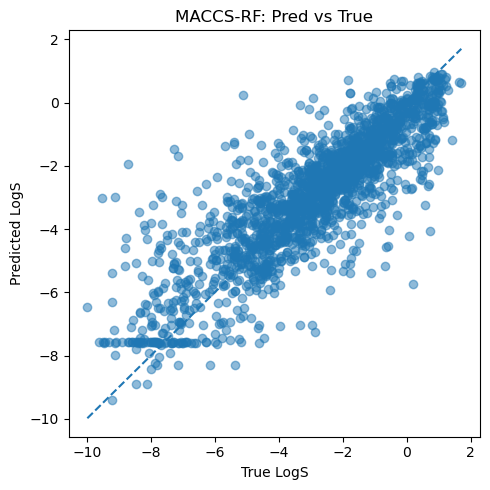

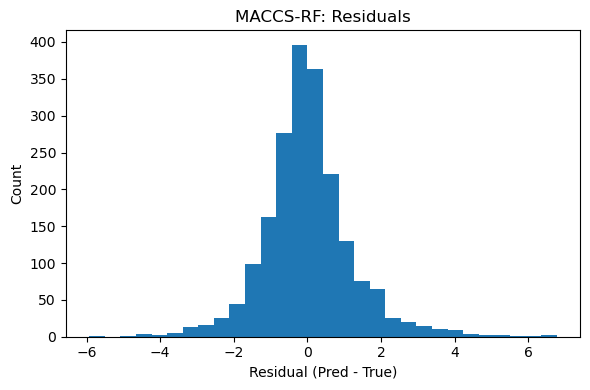

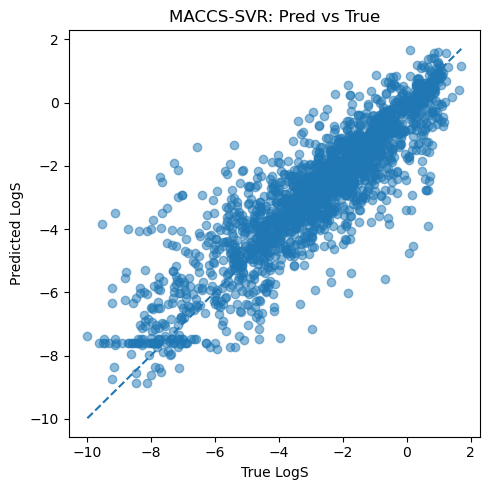

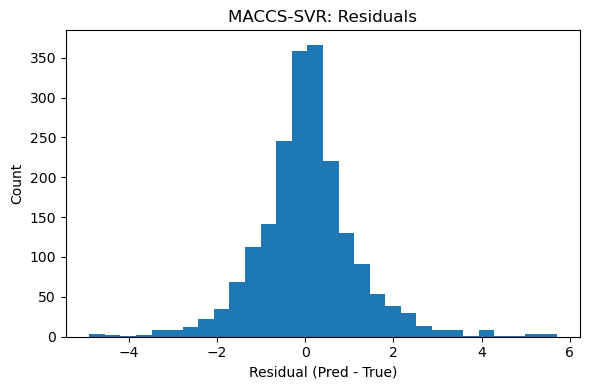

In [10]:

import matplotlib.pyplot as plt, numpy as np, pandas as pd
from pathlib import Path
Path('figures').mkdir(exist_ok=True)

def plot_pred_vs_true(y_true, y_pred, title, savepath):
    plt.figure(figsize=(5,5))
    plt.scatter(y_true, y_pred, alpha=0.5)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.plot(lims, lims, '--')
    plt.xlabel('True LogS'); plt.ylabel('Predicted LogS'); plt.title(title)
    plt.tight_layout(); plt.savefig(savepath, dpi=200); plt.show()

def plot_residuals(y_true, y_pred, title, savepath):
    resid = y_pred - y_true
    plt.figure(figsize=(6,4))
    plt.hist(resid, bins=30)
    plt.xlabel('Residual (Pred - True)'); plt.ylabel('Count'); plt.title(title)
    plt.tight_layout(); plt.savefig(savepath, dpi=200); plt.show()

plot_pred_vs_true(y_test, res_rf['yhat'],  'MACCS-RF: Pred vs True',  'figures/maccs_rf_pred_vs_true.png')
plot_residuals(y_test, res_rf['yhat'],     'MACCS-RF: Residuals',     'figures/maccs_rf_residuals.png')
plot_pred_vs_true(y_test, res_svr['yhat'], 'MACCS-SVR: Pred vs True', 'figures/maccs_svr_pred_vs_true.png')
plot_residuals(y_test, res_svr['yhat'],    'MACCS-SVR: Residuals',    'figures/maccs_svr_residuals.png')


In [11]:

# Minimal predict helper
def predict_logs_for_smiles(smiles_list: List[str], model_name='rf'):
    import joblib, numpy as np
    path = 'models/maccs_rf.joblib' if model_name.lower()=='rf' else 'models/maccs_svr.joblib'
    model = joblib.load(path)
    mats = []
    for s in smiles_list:
        mol = Chem.MolFromSmiles(s)
        if mol is None:
            raise ValueError(f"Invalid SMILES: {s}")
        fp = rdMolDescriptors.GetMACCSKeysFingerprint(mol)
        arr = np.frombuffer(fp.ToBitString().encode('ascii'), dtype='S1').astype(np.uint8) - ord(b'0')
        mats.append(arr)
    X_new = np.vstack(mats)
    return model.predict(X_new)

# Example:
# predict_logs_for_smiles(['CCO','c1ccccc1O'], 'rf')


In [12]:

manifest = {
    'seed': SEED,
    'notes': 'Self-created 80/20 split for MACCS pipelines',
    'files': {
        'split_train': 'data/splits/train_ids.txt',
        'split_test': 'data/splits/test_ids.txt',
        'metrics_csv': 'results/maccs_test_metrics.csv',
        'rf_model': 'models/maccs_rf.joblib',
        'svr_model': 'models/maccs_svr.joblib',
        'figures': [
            'figures/maccs_rf_pred_vs_true.png',
            'figures/maccs_rf_residuals.png',
            'figures/maccs_svr_pred_vs_true.png',
            'figures/maccs_svr_residuals.png'
        ]
    }
}
with open('results/maccs_run_manifest.json','w') as f:
    json.dump(manifest, f, indent=2)
print('Saved manifest → results/maccs_run_manifest.json')


Saved manifest → results/maccs_run_manifest.json


# Challenge evaluation

In [13]:
# ---- config: point to your challenge files ----
CHALLENGE_FILES = [
    "challenge_data_1.csv",
    "challenge_data_2.csv",
]

# ---- imports ----
import os, json, numpy as np, pandas as pd, joblib
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from sklearn.metrics import mean_absolute_error, r2_score

# RMSE helper (works on old/new scikit-learn)
try:
    from sklearn.metrics import root_mean_squared_error as _rmse
    def rmse(y, yhat): return float(_rmse(y, yhat))
except Exception:
    from sklearn.metrics import mean_squared_error
    def rmse(y, yhat): return float(np.sqrt(mean_squared_error(y, yhat)))

Path("results").mkdir(exist_ok=True)

# ---- small helpers ----
TARGET_NAMES = {"logs","log_s","logsol","log_solu","target","y","solubility","aqsol"}

def detect_cols(df: pd.DataFrame):
    smiles_cols = [c for c in df.columns if "smiles" in c.lower()]
    if not smiles_cols:
        raise ValueError(f"No SMILES-like column found. Columns: {list(df.columns)}")
    smiles_col = smiles_cols[0]
    y_col = next((c for c in df.columns if c.lower() in TARGET_NAMES), None)
    return smiles_col, y_col

def canonicalize(s: str):
    m = Chem.MolFromSmiles(str(s))
    return Chem.MolToSmiles(m, canonical=True) if m is not None else None

def maccs_matrix(smiles_list):
    X = []
    kept = []
    for s in smiles_list:
        m = Chem.MolFromSmiles(s)
        if m is None: 
            continue
        fp = rdMolDescriptors.GetMACCSKeysFingerprint(m)
        arr = np.frombuffer(fp.ToBitString().encode("ascii"), dtype="S1").astype(np.uint8) - ord(b"0")
        X.append(arr); kept.append(s)
    if not X:
        raise RuntimeError("No valid molecules after featurization.")
    X = np.vstack(X)
    assert X.shape[1] == 167, f"Expected 167 MACCS bits, got {X.shape[1]}"
    return X, kept

# ---- load saved models ----
rf  = joblib.load("models/maccs_rf.joblib")
svr = joblib.load("models/maccs_svr.joblib")

def evaluate_challenge(csv_path: str):
    df_raw = pd.read_csv(csv_path)
    smiles_col, y_col = detect_cols(df_raw)

    # minimal cleaning to match training assumptions
    df_raw["canonical_smiles"] = df_raw[smiles_col].map(canonicalize)
    df = df_raw.dropna(subset=["canonical_smiles"]).drop_duplicates("canonical_smiles").copy()

    # features
    X, ids = maccs_matrix(df["canonical_smiles"].tolist())

    # predict
    pred_rf  = rf.predict(X)
    pred_svr = svr.predict(X)

    out_rf  = pd.DataFrame({"canonical_smiles": ids, "y_pred": pred_rf})
    out_svr = pd.DataFrame({"canonical_smiles": ids, "y_pred": pred_svr})

    metrics = {}
    if y_col is not None and pd.api.types.is_numeric_dtype(df[y_col]):
        y_true = df[y_col].astype(float).to_numpy()[:len(ids)]
        metrics = {
            "RF" : {"rmse": rmse(y_true, pred_rf),  "mae": float(np.mean(np.abs(y_true - pred_rf))),  "r2": float(r2_score(y_true, pred_rf))},
            "SVR": {"rmse": rmse(y_true, pred_svr), "mae": float(np.mean(np.abs(y_true - pred_svr))), "r2": float(r2_score(y_true, pred_svr))},
        }

    # save
    stem = Path(csv_path).stem
    out_rf.to_csv(f"results/{stem}_predictions_rf.csv", index=False)
    out_svr.to_csv(f"results/{stem}_predictions_svr.csv", index=False)
    if metrics:
        with open(f"results/{stem}_metrics_maccs.json", "w") as f:
            json.dump(metrics, f, indent=2)

    return metrics, out_rf.head(), out_svr.head()

# ---- run on all challenge files ----
for f in CHALLENGE_FILES:
    print(f"\n=== {f} ===")
    m, head_rf, head_svr = evaluate_challenge(f)
    if m:
        print(json.dumps(m, indent=2))
    else:
        print("No ground truth column found; saved predictions only.")
    display(head_rf, head_svr)



=== challenge_data_1.csv ===
{
  "RF": {
    "rmse": 1.2112673868368766,
    "mae": 0.9846400966241794,
    "r2": -0.5728088496397579
  },
  "SVR": {
    "rmse": 1.3462240798530707,
    "mae": 1.0845516378958495,
    "r2": -0.9428112291308686
  }
}


,canonical_smiles,y_pred
0,COc1ccc(Cl)c(Nc2ncnc3cc(OCCN4CCN(C(C)=O)CC4)cc...,-4.215220
1,CCN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(CCC(c2ccc...,-3.386702
2,N#CC1(NC(=O)[C@@H]2CCCC[C@H]2C(=O)N2CCc3[nH]c4...,-4.232297
3,CN(C)C(=N)c1ccc(C(=O)N2CCN(S(=O)(=O)c3ccc4cc(B...,-3.936482
4,N#Cc1cccnc1-c1ccc(C(=O)Nc2ccccc2N)cc1,-3.535145


,canonical_smiles,y_pred
0,COc1ccc(Cl)c(Nc2ncnc3cc(OCCN4CCN(C(C)=O)CC4)cc...,-3.034428
1,CCN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(CCC(c2ccc...,-4.082027
2,N#CC1(NC(=O)[C@@H]2CCCC[C@H]2C(=O)N2CCc3[nH]c4...,-5.011377
3,CN(C)C(=N)c1ccc(C(=O)N2CCN(S(=O)(=O)c3ccc4cc(B...,-3.852933
4,N#Cc1cccnc1-c1ccc(C(=O)Nc2ccccc2N)cc1,-2.593060



=== challenge_data_2.csv ===
{
  "RF": {
    "rmse": 3.9122762430257083,
    "mae": 3.7837383409129126,
    "r2": -29.397293514827826
  },
  "SVR": {
    "rmse": 3.9488297638711156,
    "mae": 3.794147175299782,
    "r2": -29.967968399382887
  }
}


,canonical_smiles,y_pred
0,CNc1cc(Nc2cccn(-c3ccccn3)c2=O)nn2c(C(=O)N[C@@H...,-4.246245
1,CCOc1cc2nn(CCC(C)(C)O)cc2cc1NC(=O)c1cccc(C(F)F)n1,-4.513078
2,CC(C)(Oc1ccc(-c2cnc(N)c(-c3ccc(Cl)cc3)c2)cc1)C...,-4.875709
3,CC#CC(=O)N[C@H]1CCCN(c2c(F)cc(C(N)=O)c3[nH]c(C...,-3.857093
4,C=CC(=O)N1CCC[C@@H](n2nc(-c3ccc(Oc4ccccc4)cc3)...,-4.218585


,canonical_smiles,y_pred
0,CNc1cc(Nc2cccn(-c3ccccn3)c2=O)nn2c(C(=O)N[C@@H...,-3.698947
1,CCOc1cc2nn(CCC(C)(C)O)cc2cc1NC(=O)c1cccc(C(F)F)n1,-5.725295
2,CC(C)(Oc1ccc(-c2cnc(N)c(-c3ccc(Cl)cc3)c2)cc1)C...,-5.128552
3,CC#CC(=O)N[C@H]1CCCN(c2c(F)cc(C(N)=O)c3[nH]c(C...,-4.615223
4,C=CC(=O)N1CCC[C@@H](n2nc(-c3ccc(Oc4ccccc4)cc3)...,-4.948898
